# Modeling.ipynb

In [29]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_curve, auc
from prophet_rmse import stock_rmse
import seaborn as sns
import datetime
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

Loading Data from YahooFinance API (through yfinance package

In [20]:
# Load stock data for a particular ticker
ticker = "PNM"

# Get today's date
today = datetime.datetime.now()

# Subtract one day to get yesterday's date
yesterday = today - datetime.timedelta(days=1)

# Format yesterday's date as a string in yyyy-mm-dd format
yesterday_str = yesterday.strftime("%Y-%m-%d")

raw_data = yf.download(ticker, start="2010-01-01", end=yesterday_str, interval='1d')

[*********************100%***********************]  1 of 1 completed


Formatting data to input to model (predicting adjusted closing prices)

In [21]:
# Prepare data for Prophet model
df = pd.DataFrame({'ds': raw_data.index, 'y': raw_data['Adj Close']})
df.reset_index(inplace=True, drop=True)
print('done')

done


Create, fit, and generate predictions with model

In [22]:
# Create and fit the Prophet model
m = Prophet(daily_seasonality=True)

m.fit(df)

# Generate predictions for the next 30 days
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
print('done')

16:27:03 - cmdstanpy - INFO - Chain [1] start processing
16:27:07 - cmdstanpy - INFO - Chain [1] done processing


done


Create plot of model predictions vs. actual over time

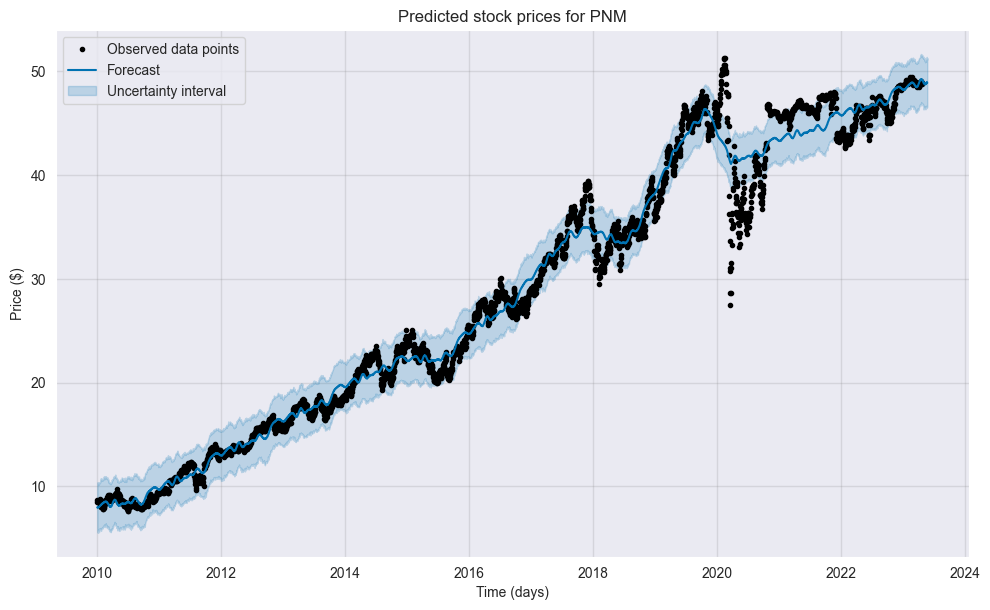

In [23]:
# Plot the predicted prices
fig = m.plot(forecast)
plt.title(f'Predicted stock prices for {ticker}')
plt.xlabel('Time (days)')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

Get plot of model performance over last 3 months with next month of adjusted closing predictions

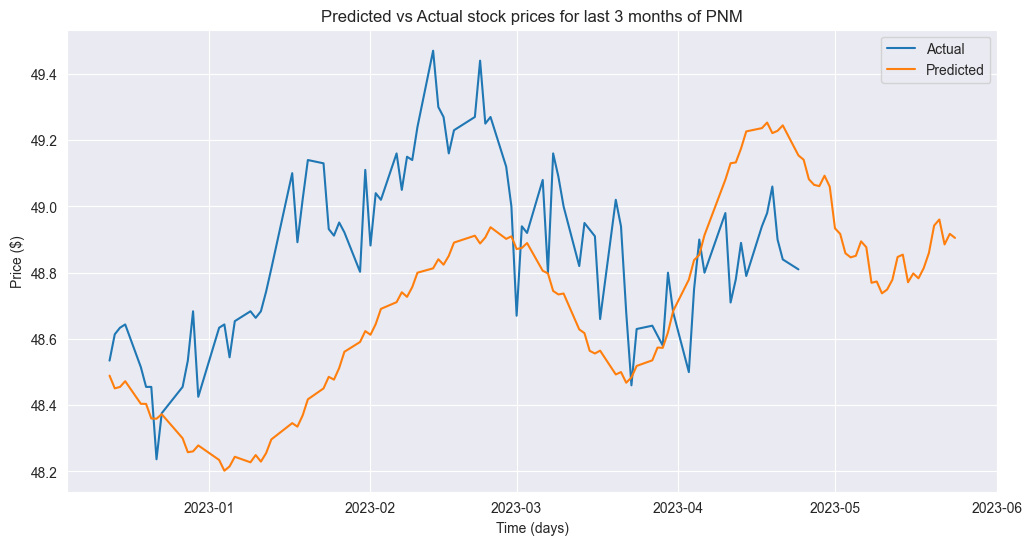

In [24]:
# Plot the predicted vs actual prices for range
last_month = forecast.iloc[-120:]
last_month_actual = raw_data.iloc[-90:]
fig2 = plt.figure(figsize=(12,6))
plt.plot(last_month_actual.index, last_month_actual['Adj Close'], label='Actual')
plt.plot(last_month.ds, last_month.yhat, label='Predicted')
plt.title(f'Predicted vs Actual stock prices for last 3 months of {ticker}')
plt.xlabel('Time (days)')
plt.ylabel('Price ($)')
plt.autoscale()
plt.legend()
plt.show()

Evaluate model performance using prophet.diagnostics cross_validation

In [28]:
# Perform cross validation with horizon of 30 days and a sliding window of 1 day
df_cv = cross_validation(m, horizon='90 days', period='45 days', initial='730 days', parallel="processes")

# Compute performance metrics
df_metrics = performance_metrics(df_cv)

# Print performance metrics
df_metrics

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
16:40:51 - cmdstanpy - INFO - Chain [1] start processing
16:40:51 - cmdstanpy - INFO - Chain [1] start processing
16:40:51 - cmdstanpy - INFO - Chain [1] start processing
16:40:51 - cmdstanpy - INFO - Chain [1] start processing
16:40:52 - cmdstanpy - INFO - Chain [1] done processing
16:40:52 - cmdstanpy - INFO - Chain [1] done processing
16:40:52 - cmdstanpy - INFO - Chain [1] start processing
16:40:52 - cmdstanpy - INFO - Chain [1] done processing
16:40:52 - cmdstanpy - INFO - Chain [1] done processing
16:40:52 - cmdstanpy - INFO - Chain [1] start processing
16:40:52 - cmdstanpy - INFO - Chain [1] start processing
16:40:52 - cmdstanpy - INFO - Chain [1] done processing
16:40:52 - cmdstanpy - INFO - Chain [1] start processing
16:40:53 - cmdstanpy - INFO - Ch

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days,9.351255,3.057982,1.910816,0.057737,0.039188,0.055807,0.481631
1,10 days,9.154111,3.025576,1.902881,0.057967,0.039587,0.056095,0.471525
2,11 days,8.704614,2.950358,1.874790,0.057446,0.039214,0.055677,0.475890
3,12 days,8.674875,2.945314,1.892465,0.058160,0.039106,0.056385,0.464102
4,13 days,9.002460,3.000410,1.956362,0.060204,0.040170,0.058411,0.440860
...,...,...,...,...,...,...,...,...
77,86 days,17.539330,4.187998,2.806916,0.088799,0.065401,0.086150,0.350610
78,87 days,17.388013,4.169894,2.776737,0.087990,0.064911,0.085220,0.353047
79,88 days,17.825930,4.222076,2.776697,0.088156,0.064515,0.085123,0.356631
80,89 days,18.889259,4.346177,2.851344,0.090628,0.066851,0.087407,0.352991


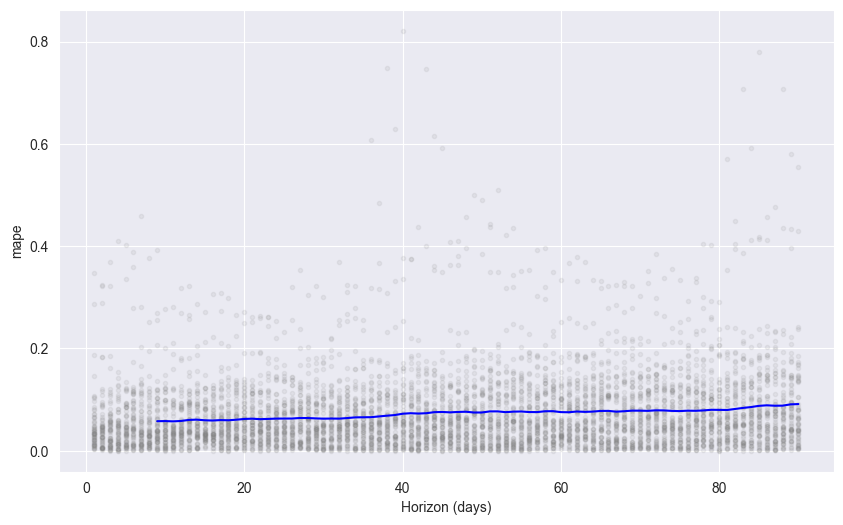

In [31]:
fig = plot_cross_validation_metric(df_cv, metric='mape')